# Data Protection & Privacy -- Exam Project

## CLASS-BASED GRAPH ANONYMIZATION FOR SOCIAL NETWORK DATA

Authors:
<br>
Kevin Cattaneo - S4944382
<br>
Riccardo Isola – S4943369


### Abstract

Nowadays social networks, such as Facebook and Instagram, have
created so far large quantities of data about interactions within
these networks.
<br>
Such data contains many private details about individuals, so
anonymization is required both for privacy of subjects and to allow
statistical operations on them
<br>
Many datasets are most naturally represented as graph
structures, with a variety of types of link connecting sets of
entities in the graph.


### Preliminary Operations


#### Imports


In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from data import User
from typing import Any
from statistics import mean
from collections.abc import Callable
from time import time
from paper import anonymize_data, Operation
from generator import generate_data
from paper import (
    divide_nodes,
    ordering_function,
    prefix_pattern,
    anonymize_uniform_list,
)
from tqdm import tqdm
from networkx import DiGraph, MultiDiGraph
from paper import Class
from random import sample, choice, seed

#### Seed for reproducibility


In [2]:
SEED = 42
N = 10**4
M = 10

# Scale free parameters
ALPHA = 0.41
BETA = 0.54
GAMMA = 0.05
DELTA_IN = 0.2
DELTA_OUT = 0

#### Data loading


In [3]:
data = generate_data(
    seed=SEED,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    delta_in=DELTA_IN,
    delta_out=DELTA_OUT,
    n=N,
    progress=False,
)

### Performance measure


In [4]:
ns = [int(n) for n in np.logspace(1, 4, num=20)]
datas = {
    n: generate_data(
        seed=SEED,
        alpha=ALPHA,
        beta=BETA,
        gamma=GAMMA,
        delta_in=DELTA_IN,
        delta_out=DELTA_OUT,
        n=n,
        progress=False,
    )
    for n in tqdm(ns)
}

100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


In [5]:
def timeit(f: Callable[[], Any]):
    start = time()
    f()
    return time() - start


x = np.array(ns)
classes: dict[int, list[frozenset[User]]] = {}
y = [
    timeit(
        lambda: classes.setdefault(
            n, divide_nodes(datas[n].following, M, ordering_function, False)
        )
    )
    for n in tqdm(ns)
]

100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


In [6]:
y1, y0 = y[-1], y[0]
x1, x0 = x[-1], x[0]
k = (y1 - y0) / (x1 - x0) ** 2
a = k
b = -2 * k * x0
c = y0 + k * x0**2
# print(a,b,c)

We decided to plot our complexity compared to a line and a praboloid


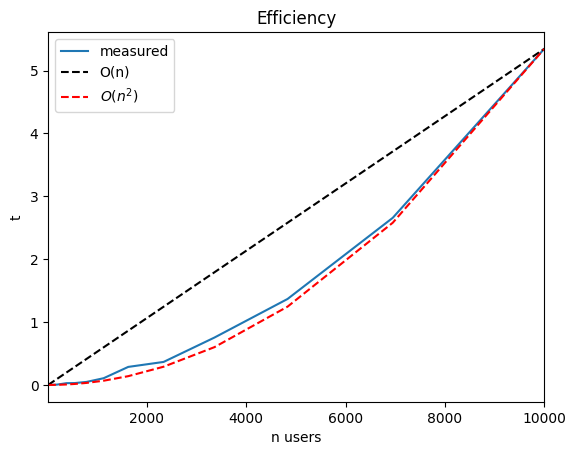

In [7]:
plt.plot(x, y, label="measured")
plt.xlim((ns[0], ns[-1]))
# plt.xscale('log')
# plt.yscale('log')
plt.plot([x[0], x[-1]], [y[0], y[-1]], "k--", label="O(n)")
plt.plot(x, a * x**2 + b * x + c, "r--", label="$O(n^2)$")
plt.xlabel("n users")
plt.ylabel("t")
plt.title("Efficiency")
plt.legend()
plt.show()

### Privacy level


#### Deanonymization


We observed how many classes are with just one user, and so how many users have been not anonymized by mixing them with other users and merging their followings.


In [8]:
x = ns
# print(x)
y = [sum(len(c) == 1 for c in classes[n]) / sum(len(c) for c in classes[n]) for n in x]

Text(0.5, 1.0, 'Fraction of deanonymized users with respect to the number of users')

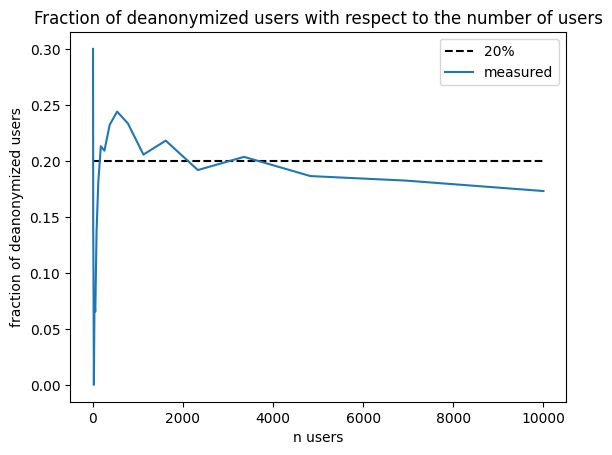

In [9]:
plt.plot([0, 10**4], [0.2, 0.2], "k--", label="20%")
plt.plot(x, y, label="measured")
plt.legend()
plt.xlabel("n users")
plt.ylabel("fraction of deanonymized users")
plt.title("Fraction of deanonymized users with respect to the number of users")

In [10]:
def find_evil_user(
    anonymized: MultiDiGraph[Class[User]], original: DiGraph[User], evil: User
) -> list[set[User]]:
    result: list[set[User]] = []
    for cls in anonymized:
        if evil not in cls.nodes:
            continue
        following = {*original[evil]}
        found: set[User] = {evil}
        for interaction in anonymized[cls]:
            if interaction.nodes & following:
                (f,) = interaction.nodes & following
                following.remove(f)
                found.add(f)
            else:
                break
        else:
            if not following:
                result.append(found)
    return result


def attack_graph(known: set[User], anonymized: MultiDiGraph[Class[User]]) -> set[User]:
    while True:
        tmp = known.copy()
        for cls in anonymized:
            if len(cls.nodes - known) == 1:
                (u,) = cls.nodes - known
                tmp.add(u)
        if tmp == known:
            return tmp
        known = tmp

In [11]:
NUM = 10

seed(SEED)
ls = [int(l) for l in np.linspace(1, N, num=NUM)]
anonymized_lists = anonymize_data(data, Operation.uniform_list, M, prefix_pattern(M))
y: list[int] = []
y2: list[int] = []
y3: list[int] = []
y4: list[int] = []

known: set[User] = set()
evils = sample([*data.following], k=int(ls[-1]))
last_l = 0
useless = {
    next(iter(cls.nodes)) for cls in anonymized_lists.classes if len(cls.nodes) == 1
}
attacked: set[User] = set()
for l in tqdm(ls):
    for evil in evils[last_l:l]:
        possibles = find_evil_user(anonymized_lists.following, data.following, evil)
        if len(possibles) != 1:
            continue
        (found,) = possibles
        known |= found
        attacked |= found
    last_l = l
    weak = known | useless
    attacked = attack_graph(attacked, anonymized_lists.following)
    y.append(len(attacked))
    y2.append(len(weak))
    y3.append(sum(u in attacked and v in attacked for u, v in data.following.edges()))
    y4.append(sum(u in weak and v in weak for u, v in data.following.edges()))

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


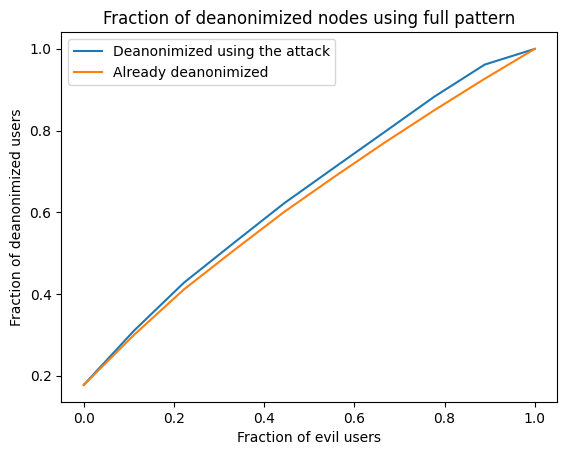

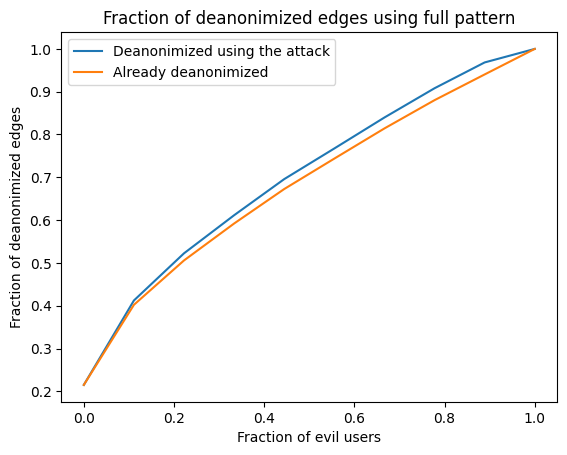

In [12]:
plt.plot(np.array(ls) / N, np.array(y) / N, label="Deanonimized using the attack")
plt.plot(np.array(ls) / N, np.array(y2) / N, label="Already deanonimized")
plt.title("Fraction of deanonimized nodes using full pattern")
plt.legend()
plt.xlabel("Fraction of evil users")
plt.ylabel("Fraction of deanonimized users")
plt.show()


plt.plot(
    np.array(ls) / N,
    np.array(y3) / len(data.following.edges()),
    label="Deanonimized using the attack",
)
plt.plot(
    np.array(ls) / N,
    np.array(y4) / len(data.following.edges()),
    label="Already deanonimized",
)
plt.title("Fraction of deanonimized edges using full pattern")
plt.legend()
plt.xlabel("Fraction of evil users")
plt.ylabel("Fraction of deanonimized edges")
plt.show()

A big number of compromised nodes doesn't give the attacker a greater advantage

In [13]:
NUM = 10

ls = [int(l) for l in np.linspace(1, N, num=NUM)]
anonymized_partitioning = anonymize_data(
    data, Operation.partitioning, M, prefix_pattern(M)
)
y: list[int] = []
y2: list[int] = []
y3: list[int] = []
y4: list[int] = []

known: set[User] = set()
evils = sample([*data.following], k=int(ls[-1]))
last_l = 0
useless = {
    next(iter(cls.nodes))
    for cls in anonymized_partitioning.classes
    if len(cls.nodes) == 1
}
attacked: set[User] = set()
for l in tqdm(ls):
    known = {*evils[:l]}
    weak = known | useless
    attacked |= known
    attacked = attack_graph(attacked, anonymized_partitioning.following)
    y.append(len(attacked))
    y2.append(len(weak))
    y3.append(sum(u in attacked and v in attacked for u, v in data.following.edges()))
    y4.append(sum(u in weak and v in weak for u, v in data.following.edges()))

100%|██████████| 10/10 [00:00<00:00, 50.62it/s]


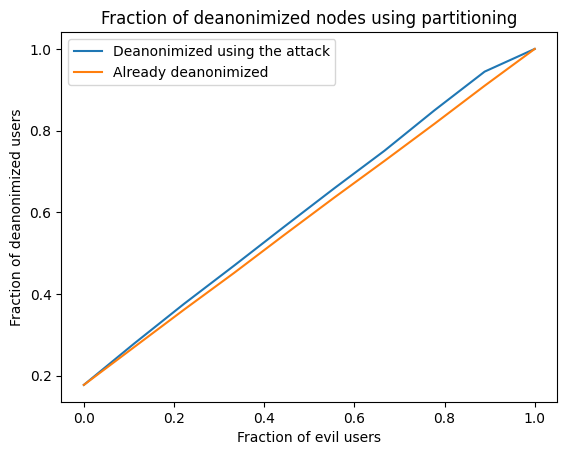

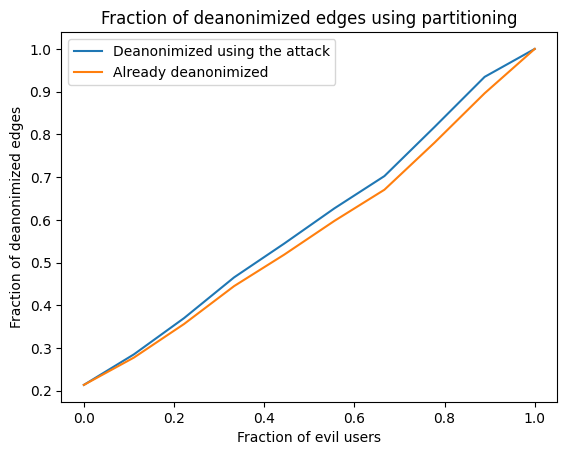

In [14]:
plt.plot(np.array(ls) / N, np.array(y) / N, label="Deanonimized using the attack")
plt.plot(np.array(ls) / N, np.array(y2) / N, label="Already deanonimized")
plt.title("Fraction of deanonimized nodes using partitioning")
plt.legend()
plt.xlabel("Fraction of evil users")
plt.ylabel("Fraction of deanonimized users")
plt.show()


plt.plot(
    np.array(ls) / N,
    np.array(y3) / len(data.following.edges()),
    label="Deanonimized using the attack",
)
plt.plot(
    np.array(ls) / N,
    np.array(y4) / len(data.following.edges()),
    label="Already deanonimized",
)
plt.title("Fraction of deanonimized edges using partitioning")
plt.legend()
plt.xlabel("Fraction of evil users")
plt.ylabel("Fraction of deanonimized edges")
plt.show()

Since in the partitioning approach the attacker cannot use it's friends to deanonymize more nodes:
- the "already anonymized" line in the nodes plot has a linear shape
- the lines in the edges plot have a slower increase


## Utility measure (by queries)


### How many older people are connected with younger groups?

In other terms n people with age > 50 --> n people with age < 20


In [15]:
def sample_graph_full_pattern(G: nx.MultiDiGraph[Class[User]]) -> nx.DiGraph[User]:
    chosen: set[User] = set()
    mapping: dict[Class[User], User] = {}
    for cls in G:
        node = choice(list(cls.nodes - chosen))
        chosen.add(node)
        mapping[cls] = node
    return nx.relabel_nodes(G, mapping)


def sample_graph_partitioning(G: nx.MultiDiGraph[Class[User]]) -> nx.DiGraph[User]:
    result: nx.DiGraph[User] = nx.DiGraph()
    for u, v in G.edges():
        result.add_edge(choice([*u.nodes]), choice([*v.nodes]))
    return result


seed(SEED)
deanonymized_lists = sample_graph_full_pattern(anonymized_lists.following)
deanonymized_partitioning = sample_graph_partitioning(anonymized_partitioning.following)

In [16]:
def calculate_pedofiles(users: nx.DiGraph[User]):
    children = {u for u in users if u.age < 20}
    older = {u for u in users if u.age >= 50 and {*users[u]} & children}
    return len(older)


older_original = calculate_pedofiles(data.following)
older_lists = calculate_pedofiles(deanonymized_lists)
older_partitioning = calculate_pedofiles(deanonymized_partitioning)
print(
    f"Perturbation of the query using lists {abs(older_lists-older_original)/older_original*100:.2f}%"
)
print(
    f"Perturbation of the query using partitioning {abs(older_partitioning-older_original)/older_original*100:.2f}%"
)

Perturbation of the query using lists 23.92%
Perturbation of the query using partitioning 18.73%


### How many users are connected to users with in-degree greater than 1000


In [17]:
K = 1000


def calculate_cultists(users: nx.DiGraph[User], k: int):
    famous = {u for u in users if users.in_degree(u) > k}
    return len([u for u in users if {*users[u]} & famous])


cultists_original = calculate_cultists(data.following, K)
cultists_lists = calculate_cultists(deanonymized_lists, K)
cultists_partitioning = calculate_cultists(deanonymized_partitioning, K)
print(
    f"Perturbation of the query using lists {abs(cultists_lists-cultists_original)/cultists_original*100:.2f}%"
)
print(
    f"Perturbation of the query using partitioning {abs(cultists_partitioning-cultists_original)/cultists_original*100:.2f}%"
)

Perturbation of the query using lists 0.00%
Perturbation of the query using partitioning 2.00%


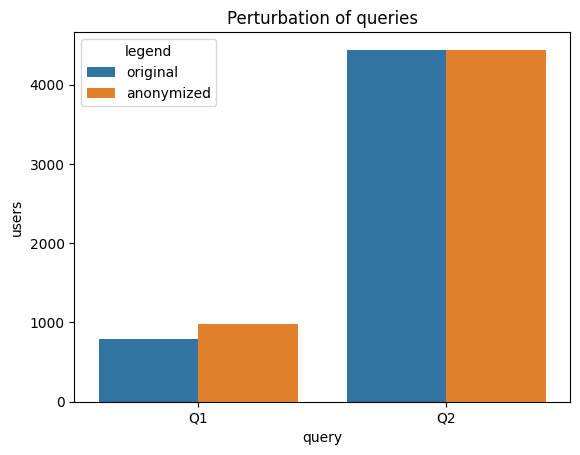

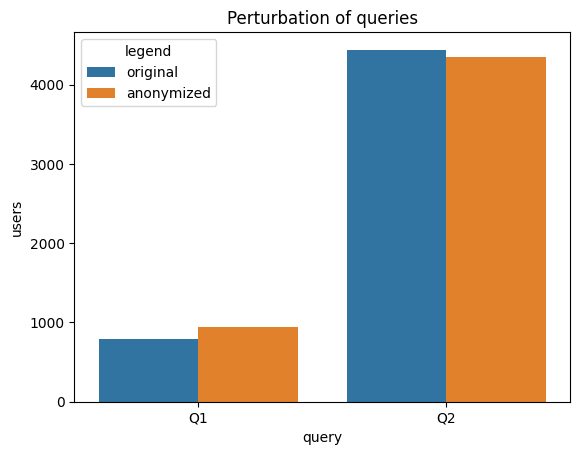

In [18]:
import seaborn as sns

df = {
    "question": ["Q1", "Q1", "Q2", "Q2"],
    "value": [older_original, older_lists, cultists_original, cultists_lists],
    "legend": ["original", "anonymized", "original", "anonymized"],
}

sns.barplot(df, x="question", y="value", hue="legend")
plt.xlabel("query")
plt.ylabel("users")
plt.title("Perturbation of queries")
plt.show()


import seaborn as sns

df = {
    "question": ["Q1", "Q1", "Q2", "Q2"],
    "value": [
        older_original,
        older_partitioning,
        cultists_original,
        cultists_partitioning,
    ],
    "legend": ["original", "anonymized", "original", "anonymized"],
}

sns.barplot(df, x="question", y="value", hue="legend")
plt.xlabel("query")
plt.ylabel("users")
plt.title("Perturbation of queries")
plt.show()

In [19]:
def sample_graph_lists(G: nx.MultiDiGraph[Class[User]]) -> nx.DiGraph[User]:
    mapping: dict[Class[User], User] = {}
    to_do = {*G}
    with tqdm(total=len(to_do)) as pbar:
        while to_do:
            cls = choice([*to_do])
            to_do.remove(cls)
            pbar.update(1)
            node = choice(list(cls.nodes))
            mapping[cls] = node
            while True:
                tmp = to_do.copy()
                for c in to_do:
                    if len(c.nodes - cls.nodes) != 1:
                        continue
                    tmp.remove(c)
                    pbar.update(1)
                    (node,) = c.nodes - cls.nodes
                    mapping[c] = node
                    cls = c
                    break
                if len(to_do) == len(tmp):
                    break
                to_do = tmp
        return nx.relabel_nodes(G, mapping)

In [20]:
seed(SEED)

result: list[float] = []
ks = [*range(20)]
cls = divide_nodes(data.following, 20, ordering_function, progress=False)
for k in ks:
    print(k)
    anonymized = anonymize_uniform_list(data, cls, prefix_pattern(k))
    older_k = calculate_pedofiles(sample_graph_lists(anonymized.following))
    result.append(older_k)

1


100%|██████████| 10000/10000 [00:00<00:00, 23128.21it/s]


2


100%|██████████| 10000/10000 [00:03<00:00, 2822.59it/s]


7


100%|██████████| 10000/10000 [00:05<00:00, 1667.97it/s]


21


100%|██████████| 10000/10000 [00:13<00:00, 725.04it/s]


59


100%|██████████| 10000/10000 [00:17<00:00, 582.11it/s]


166


100%|██████████| 10000/10000 [00:38<00:00, 258.56it/s]


464


100%|██████████| 10000/10000 [01:22<00:00, 120.57it/s]


1291


100%|██████████| 10000/10000 [01:09<00:00, 144.35it/s]


3593


100%|██████████| 10000/10000 [04:43<00:00, 35.22it/s]


10000


100%|██████████| 10000/10000 [04:40<00:00, 35.60it/s]


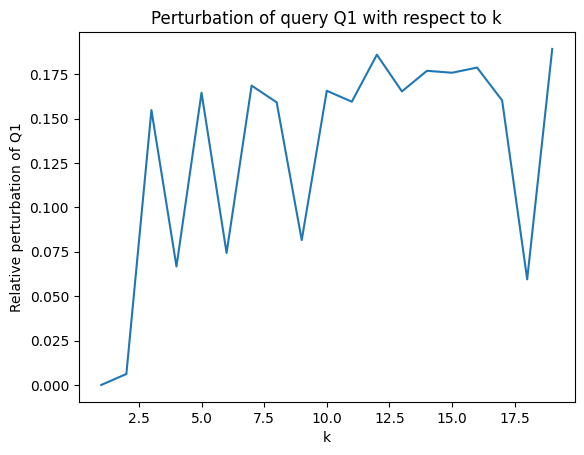

In [32]:
plt.title("Perturbation of query Q1 with respect to k")
plt.xlabel("k")
plt.ylabel("Relative perturbation of Q1")
plt.plot(ks, np.abs(np.array(result) - older_original) / older_original)

The perturbation in this example is independent to the value of k, so for this model a high value of k is better since it increase the privacy level without compromising the utility

### Statistical informations

Then we decide to plot some common statistical measurements


We selected:

-   Node removal robustness
-   Diameter and mean degree
-   Closeness
-   Betweenness


In [22]:
def robustness(G: nx.DiGraph[Any]) -> list[float]:
    G = G.copy()
    initial_size = len(max(nx.weakly_connected_components(G), key=len))
    result: list[float] = []
    for node in tqdm(G.copy().nodes()):
        result.append(
            len(max(nx.weakly_connected_components(G), key=len)) / initial_size
        )
        G.remove_node(node)
    return result


y_original = robustness(data.following)
y_anonymized = robustness(deanonymized_partitioning)

100%|██████████| 8923/8923 [01:27<00:00, 101.60it/s] 


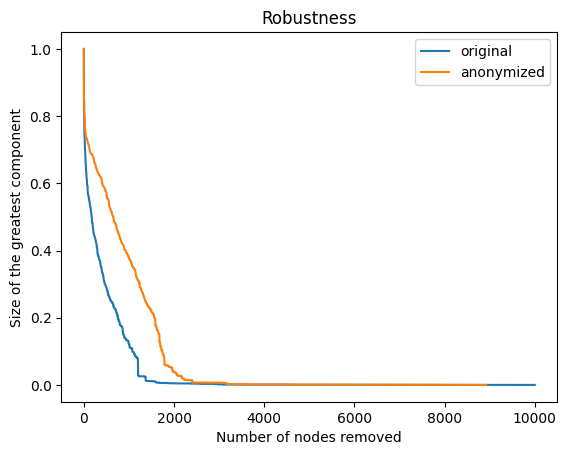

In [23]:
plt.title("Robustness")
plt.plot(y_original, label="original")
plt.plot(y_anonymized, label="anonymized")
plt.xlabel("Number of nodes removed")
plt.ylabel("Size of the greatest component")
plt.legend()
plt.show()

In [24]:
original_diameter = nx.approximation.diameter(nx.Graph(data.following))
largest_cc = max(nx.connected_components(nx.Graph(deanonymized_partitioning)), key=len)
anonymized_diameter = nx.approximation.diameter(
    nx.Graph(deanonymized_partitioning).subgraph(largest_cc)
)

Perturbation of the query 0.00%


Text(0, 0.5, 'Diameter')

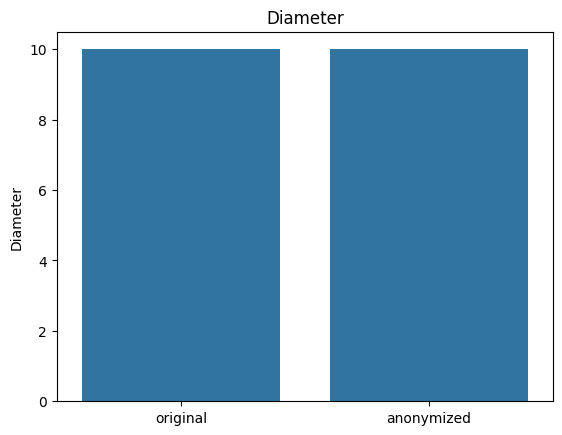

In [25]:
print(
    f"Perturbation of the query {abs(original_diameter-anonymized_diameter)/original_diameter*100:.2f}%"
)

sns.barplot({"original": original_diameter, "anonymized": anonymized_diameter})
plt.title("Diameter")
plt.ylabel("Diameter")

In [26]:
original_degree = mean(len(data.following[d]) for d in data.following)
anonymized_degree = mean(
    len(deanonymized_partitioning[d]) for d in deanonymized_partitioning
)

Perturbation of the query 12.07%


Text(0, 0.5, 'Degree')

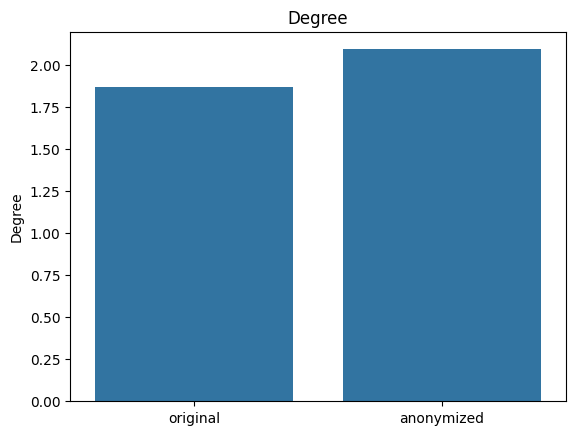

In [27]:
print(
    f"Perturbation of the query {abs(original_degree-anonymized_degree)/original_degree*100:.2f}%"
)

sns.barplot({"original": original_degree, "anonymized": anonymized_degree})
plt.title("Degree")
plt.ylabel("Degree")

In [28]:
original_closeness = mean(nx.closeness_centrality(data.following).values())
anonymized_closeness = mean(nx.closeness_centrality(deanonymized_partitioning).values())

Perturbation of the query 63.82%


Text(0, 0.5, 'Closeness')

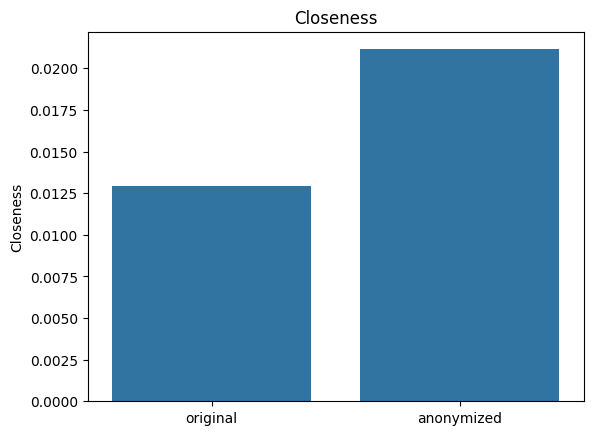

In [29]:
print(
    f"Perturbation of the query {abs(original_closeness-anonymized_closeness)/original_closeness*100:.2f}%"
)

sns.barplot({"original": original_closeness, "anonymized": anonymized_closeness})
plt.title("Closeness")
plt.ylabel("Closeness")

In [30]:
original_betweenness = mean(
    nx.betweenness_centrality(data.following, k=10**3).values()
)
anonymized_betweenness = mean(
    nx.betweenness_centrality(deanonymized_partitioning, k=10**3).values()
)

Perturbation of the query 194.65%


Text(0, 0.5, 'Betweenness')

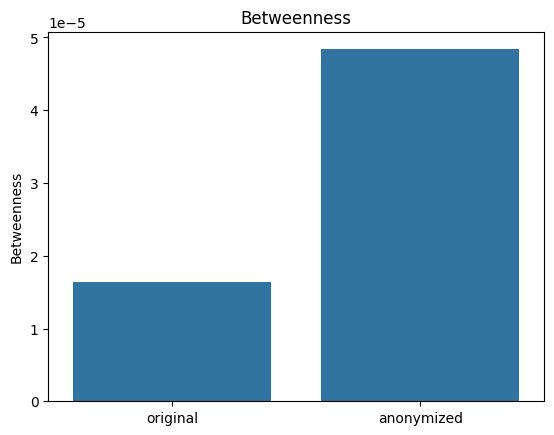

In [31]:
print(
    f"Perturbation of the query {abs(original_betweenness-anonymized_betweenness)/original_betweenness*100:.2f}%"
)

sns.barplot({"original": original_betweenness, "anonymized": anonymized_betweenness})
plt.title("Betweenness")
plt.ylabel("Betweenness")